---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 3. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

Use this first cell to import the necessary libraries.

In [241]:
import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc);
2.	create the dataloader to load the data.



In [242]:
def read_data(file_path):
    sentences = []
    current_sentence = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
            else:
                parts = line.split(' ', 1)  # Split into word and tag
                if len(parts) == 2:
                    word, tag = parts
                    current_sentence.append((word, tag))
        if current_sentence:
            sentences.append(current_sentence)
    return sentences


def build_vocab(sentences):
    word_counts = {}
    for sentence in sentences:
        for word, tag in sentence:
            word_counts[word] = word_counts.get(word, 0) + 1
    word_to_ix = {'<PAD>': 0, '<UNK>': 1}
    for word in word_counts:
        word_to_ix[word] = len(word_to_ix)
    return word_to_ix


class NERDataset(data.Dataset):
    def __init__(self, sentences, word_to_ix, tag_to_ix):
        self.sentences = sentences
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        word_indices = [self.word_to_ix.get(word, self.word_to_ix['<UNK>']) for word, _ in sentence]
        tag_indices = [self.tag_to_ix[tag] for _, tag in sentence]
        return torch.tensor(word_indices, dtype=torch.long), torch.tensor(tag_indices, dtype=torch.long)


def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=-100)
    return inputs_padded, targets_padded


In [243]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read all sentences
file_path = "ner_dataset.txt"
sentences = read_data(file_path)

# Split into train (70%), temp (30%)
train_sentences, temp_sentences = train_test_split(sentences, test_size=0.3,
                                                   random_state=42)

# Split temp into validation (50%) and test (50%) (each 15% of total)
val_sentences, test_sentences = train_test_split(temp_sentences,
                                                 test_size=0.5, random_state=42)

# Create vocabs
tag_to_ix = {'O': 0, 'I-LOC': 1, 'I-PER': 2, 'I-ORG': 3, 'I-MISC': 4}
word_to_ix = build_vocab(train_sentences)

# Create datasets
train_dataset = NERDataset(train_sentences, word_to_ix, tag_to_ix)
val_dataset = NERDataset(val_sentences, word_to_ix, tag_to_ix)
test_dataset = NERDataset(test_sentences, word_to_ix, tag_to_ix)

# Create dataloaders
train_dataloader = data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)

test_dataloader = data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)




---

# 2. **Neural Networks**

Here, you need to:

1.	create a Recurrent Neural Network (RNN) (such as RNN, GRU, LSTM) to tackle the problem;
2.	create a Transformer Network to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train the models;
5.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.

Bidirectional LSTM

In [244]:
# Define our BiLSTM

class BiLSTM(nn.Module):
    #define the parent Model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(BiLSTM,self).__init__()
        # Embedding layer to convert word indices to vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        # Fully connected layer to map to output dimensions (*2 -- bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    # Define the forward pass
    def forward(self, x):
        # Embed the input and apply dropout
        embedded = self.dropout(self.embedding(x))
        # Pass through the BiLSTM
        lstm_out, _ = self.lstm(embedded) 
        # Apply dropout to the LSTM output
        lstm_out = self.dropout(lstm_out)
        # Pass through the fully connected layer to get logits
        logits = self.fc(lstm_out)
        return logits.view(-1,5)
    

**Transformer**

In [245]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output


class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x
    

class TransformerNER(nn.Module):
    def __init__(self, vocab_size, tagset_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, pad_idx=0):
        super(TransformerNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.fc = nn.Linear(d_model, tagset_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # Create padding mask: shape [batch, 1, 1, seq_len]
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)

        x = self.embedding(src)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        for layer in self.encoder_layers:
            x = layer(x, src_mask)

        output = self.fc(x)
        return output.view(-1,5)

In [ ]:
# Define an accuracy function to deal with the padded values
def masked_accuracy(y_true, y_pred):
    """
    Calculate masked accuracy for predicted labels.

    Parameters:
    y_true (tensor): True labels.
    y_pred (tensor): Predicted logits.

    Returns:
    accuracy (tensor): Masked accuracy.

    """
    # Create the mask, i.e., the values that will be ignored
    mask = (y_true != -100)

    # Perform argmax to get the predicted values
    y_pred_class = y_pred.argmax(axis=-1)

    # Compare the true values with the predicted ones
    matches_true_pred = (y_true == y_pred_class) and mask
    print(matches_true_pred)
    print(mask)

    # Compute masked accuracy (quotient between the total matches and the total valid values, i.e., the amount of non-masked values)
    masked_acc = torch.sum(matches_true_pred) / torch.sum(mask)
    
    return masked_acc


In [ ]:
# Define a training loop
def train(dataloader, model, criterion, optimizer, epoch):
    model.train()
    for sentences, labels in dataloader:
        optimizer.zero_grad()
        output = model(sentences)
        loss = criterion(output, labels.view(-1))
        loss.backward()
        optimizer.step()
    bacc = masked_accuracy(labels.view(-1).numpy(), output.argmax(dim=-1).cpu().numpy())
    print(f"TRAIN -- Epoch {epoch+1}, Loss: {loss.item():.4f}, Balanced Accuracy: {bacc:.4f}")
    return bacc, loss.item()

def validation(dataloader, model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sentences, labels in dataloader:
            output = model(sentences)
            all_preds.append(output.argmax(dim=-1).cpu().numpy())
            all_labels.append(labels.view(-1).cpu().numpy())

        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        #bacc = masked_accuracy(all_labels, all_preds)   
        bacc = masked_accuracy(all_labels, all_preds)
        print(f"VAL -- Balanced Accuracy: {bacc}")
    return bacc

# Define a function to plot the loss curve
def plot_loss(model_name, train_losses):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss for ' + model_name)

    plt.show()


# Define a function to plot the accuracy curve
def plot_acc(model_name, train_accuracies, val_accuracies):
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy', linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training vs Validation Accuracy for ' + model_name)

    plt.show()

# Loop for training, evaluating and plotting
def train_plots(model, model_name, criterion, optimizer, num_epochs=100):
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    
    model.train()
    for epoch in range(num_epochs):
        bacc, loss = train(train_dataloader, model, criterion, optimizer,epoch)
        train_losses.append(loss)
        train_accuracies.append(bacc)
        vbacc = validation(val_dataloader, model)
        val_accuracies.append(vbacc)
    
    plot_loss(model_name, train_losses)
    plot_acc(model_name, train_accuracies, val_accuracies)

    return val_accuracies[-1]


TRAIN -- Epoch 1, Loss: 0.4837, Balanced Accuracy: 0.3333
VAL -- Balanced Accuracy: 0.16666666666666666
TRAIN -- Epoch 2, Loss: 0.2317, Balanced Accuracy: 0.3333
VAL -- Balanced Accuracy: 0.16666666666666666
TRAIN -- Epoch 3, Loss: 0.5191, Balanced Accuracy: 0.3438
VAL -- Balanced Accuracy: 0.18581536599372953
TRAIN -- Epoch 4, Loss: 0.4156, Balanced Accuracy: 0.4000
VAL -- Balanced Accuracy: 0.26380287546835607
TRAIN -- Epoch 5, Loss: 0.8212, Balanced Accuracy: 0.2500
VAL -- Balanced Accuracy: 0.31026407292111946
TRAIN -- Epoch 6, Loss: 0.5474, Balanced Accuracy: 0.2222
VAL -- Balanced Accuracy: 0.3705491039428159
TRAIN -- Epoch 7, Loss: 0.2964, Balanced Accuracy: 0.5714
VAL -- Balanced Accuracy: 0.39632479447637986
TRAIN -- Epoch 8, Loss: 0.3258, Balanced Accuracy: 0.2951
VAL -- Balanced Accuracy: 0.4085050705326705
TRAIN -- Epoch 9, Loss: 0.2924, Balanced Accuracy: 0.4555
VAL -- Balanced Accuracy: 0.42467050361641645


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 10, Loss: 0.4573, Balanced Accuracy: 0.5000
VAL -- Balanced Accuracy: 0.43411823273280964


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 11, Loss: 0.1628, Balanced Accuracy: 0.7047
VAL -- Balanced Accuracy: 0.46348731881005395
TRAIN -- Epoch 12, Loss: 0.2082, Balanced Accuracy: 0.6000
VAL -- Balanced Accuracy: 0.4620754408263723
TRAIN -- Epoch 13, Loss: 0.2359, Balanced Accuracy: 0.4307
VAL -- Balanced Accuracy: 0.4746528144916346
TRAIN -- Epoch 14, Loss: 0.2102, Balanced Accuracy: 0.5000
VAL -- Balanced Accuracy: 0.474167176734956
TRAIN -- Epoch 15, Loss: 0.1934, Balanced Accuracy: 0.5965
VAL -- Balanced Accuracy: 0.47080747523782684
TRAIN -- Epoch 16, Loss: 0.0889, Balanced Accuracy: 0.6691
VAL -- Balanced Accuracy: 0.4858911486640484


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 17, Loss: 0.1399, Balanced Accuracy: 0.5000
VAL -- Balanced Accuracy: 0.46822849778322156
TRAIN -- Epoch 18, Loss: 0.1044, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.48289952270138353
TRAIN -- Epoch 19, Loss: 0.0637, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.49203495823170157
TRAIN -- Epoch 20, Loss: 0.2810, Balanced Accuracy: 0.4667
VAL -- Balanced Accuracy: 0.499269594470388
TRAIN -- Epoch 21, Loss: 0.0513, Balanced Accuracy: 0.7431
VAL -- Balanced Accuracy: 0.4931749489178589


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 22, Loss: 0.0136, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.49223871925315965
TRAIN -- Epoch 23, Loss: 0.0945, Balanced Accuracy: 0.6458
VAL -- Balanced Accuracy: 0.5110411900169091
TRAIN -- Epoch 24, Loss: 0.0306, Balanced Accuracy: 0.7481
VAL -- Balanced Accuracy: 0.503221003667051
TRAIN -- Epoch 25, Loss: 0.0169, Balanced Accuracy: 0.5000
VAL -- Balanced Accuracy: 0.5041484915814998


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 26, Loss: 0.0686, Balanced Accuracy: 0.5969
VAL -- Balanced Accuracy: 0.5032597569565159
TRAIN -- Epoch 27, Loss: 0.0279, Balanced Accuracy: 0.7778
VAL -- Balanced Accuracy: 0.4882878420447012
TRAIN -- Epoch 28, Loss: 0.0646, Balanced Accuracy: 0.7000
VAL -- Balanced Accuracy: 0.49521507728776665


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 29, Loss: 0.1108, Balanced Accuracy: 0.6957
VAL -- Balanced Accuracy: 0.5052588166708664


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 30, Loss: 0.0652, Balanced Accuracy: 0.6524
VAL -- Balanced Accuracy: 0.49674147128584356


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 31, Loss: 0.0169, Balanced Accuracy: 0.6596
VAL -- Balanced Accuracy: 0.49878042694695685
TRAIN -- Epoch 32, Loss: 0.1346, Balanced Accuracy: 0.6603
VAL -- Balanced Accuracy: 0.5161700576121814
TRAIN -- Epoch 33, Loss: 0.0307, Balanced Accuracy: 0.6250
VAL -- Balanced Accuracy: 0.5138115301326377
TRAIN -- Epoch 34, Loss: 0.0709, Balanced Accuracy: 0.6618
VAL -- Balanced Accuracy: 0.5049155911225993
TRAIN -- Epoch 35, Loss: 0.0174, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5253502423225951
TRAIN -- Epoch 36, Loss: 0.0119, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.5179544377724918
TRAIN -- Epoch 37, Loss: 0.0063, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5128160209722705
TRAIN -- Epoch 38, Loss: 0.0032, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.520761668118304
TRAIN -- Epoch 39, Loss: 0.0226, Balanced Accuracy: 0.8095
VAL -- Balanced Accuracy: 0.5121625061827034
TRAIN -- Epoch 40, Loss: 0.0161, Balanced Accuracy: 0.8000
VAL -

c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 42, Loss: 0.1035, Balanced Accuracy: 0.7000
VAL -- Balanced Accuracy: 0.5225381262571481
TRAIN -- Epoch 43, Loss: 0.0139, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5122491429466568
TRAIN -- Epoch 44, Loss: 0.0090, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.5314752113361999
TRAIN -- Epoch 45, Loss: 0.0191, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5250296523554542
TRAIN -- Epoch 46, Loss: 0.0236, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5205870461086978
TRAIN -- Epoch 47, Loss: 0.0042, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5259412799838191
TRAIN -- Epoch 48, Loss: 0.0033, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5208992059806217
TRAIN -- Epoch 49, Loss: 0.0138, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5337389783751084


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 50, Loss: 0.0019, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.5184203474053346
TRAIN -- Epoch 51, Loss: 0.0182, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5283767989309549
TRAIN -- Epoch 52, Loss: 0.0028, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5223415522462435
TRAIN -- Epoch 53, Loss: 0.0018, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.521775472302997


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 54, Loss: 0.0050, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5195523175438087
TRAIN -- Epoch 55, Loss: 0.0095, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5192388255333963
TRAIN -- Epoch 56, Loss: 0.0044, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5179725901439304


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 57, Loss: 0.0263, Balanced Accuracy: 0.7448
VAL -- Balanced Accuracy: 0.5280050011800866
TRAIN -- Epoch 58, Loss: 0.0061, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5258067805913104
TRAIN -- Epoch 59, Loss: 0.0008, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5198321011472569
TRAIN -- Epoch 60, Loss: 0.0272, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5315500024738952
TRAIN -- Epoch 61, Loss: 0.0016, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5371235628783921


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 62, Loss: 0.1489, Balanced Accuracy: 0.7455
VAL -- Balanced Accuracy: 0.5397071686303776
TRAIN -- Epoch 63, Loss: 0.0036, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5244068445921263
TRAIN -- Epoch 64, Loss: 0.0075, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5276413807049625
TRAIN -- Epoch 65, Loss: 0.0115, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.5232166807809308
TRAIN -- Epoch 66, Loss: 0.0003, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5176234886108376
TRAIN -- Epoch 67, Loss: 0.0083, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5361960958098763
TRAIN -- Epoch 68, Loss: 0.0179, Balanced Accuracy: 0.7971
VAL -- Balanced Accuracy: 0.5257227656119847
TRAIN -- Epoch 69, Loss: 0.0035, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5360859222534308
TRAIN -- Epoch 70, Loss: 0.0008, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5345573606785864
TRAIN -- Epoch 71, Loss: 0.0197, Balanced Accuracy: 0.7917
VAL -

c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 78, Loss: 0.0008, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5273189179392205
TRAIN -- Epoch 79, Loss: 0.0063, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5427088097462811
TRAIN -- Epoch 80, Loss: 0.0085, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5491587818276735
TRAIN -- Epoch 81, Loss: 0.0011, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5435383609670087
TRAIN -- Epoch 82, Loss: 0.0089, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5555940029934946
TRAIN -- Epoch 83, Loss: 0.0023, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5445681591519367


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 84, Loss: 0.0298, Balanced Accuracy: 0.6875
VAL -- Balanced Accuracy: 0.5556993936924762
TRAIN -- Epoch 85, Loss: 0.0029, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5485017597516079
TRAIN -- Epoch 86, Loss: 0.0007, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5559316332599288


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 87, Loss: 0.0008, Balanced Accuracy: 0.5000
VAL -- Balanced Accuracy: 0.5541618656982563
TRAIN -- Epoch 88, Loss: 0.0007, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5452796426782719
TRAIN -- Epoch 89, Loss: 0.0004, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5471902935242617
TRAIN -- Epoch 90, Loss: 0.0004, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5434303409121567
TRAIN -- Epoch 91, Loss: 0.0011, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5498950942274452


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 92, Loss: 0.0108, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5465288188236609
TRAIN -- Epoch 93, Loss: 0.0000, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.5534188600196801
TRAIN -- Epoch 94, Loss: 0.0033, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5548098090203838
TRAIN -- Epoch 95, Loss: 0.0048, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.5557304333864489
TRAIN -- Epoch 96, Loss: 0.0104, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5485597820874385
TRAIN -- Epoch 97, Loss: 0.0033, Balanced Accuracy: 0.8333
VAL -- Balanced Accuracy: 0.5574672649079818
TRAIN -- Epoch 98, Loss: 0.0034, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.544902516807045
TRAIN -- Epoch 99, Loss: 0.0026, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.5479336478468945
TRAIN -- Epoch 100, Loss: 0.0009, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.542108754501424


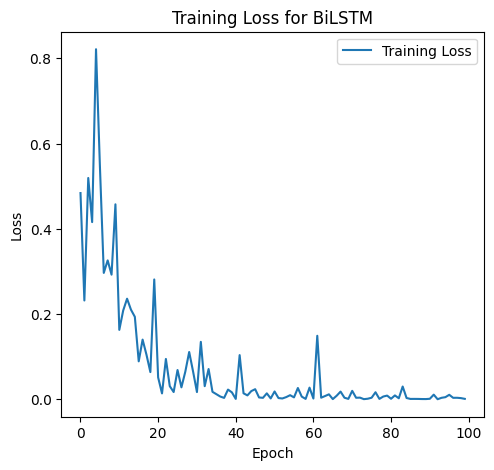

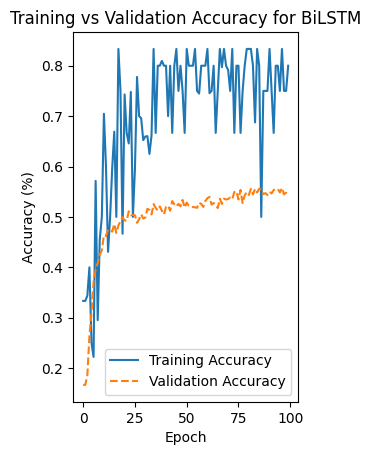

TRAIN -- Epoch 1, Loss: 1.1641, Balanced Accuracy: 0.2000
VAL -- Balanced Accuracy: 0.16666666666666666
TRAIN -- Epoch 2, Loss: 0.4544, Balanced Accuracy: 0.2500
VAL -- Balanced Accuracy: 0.16666666666666666
TRAIN -- Epoch 3, Loss: 1.0838, Balanced Accuracy: 0.2000
VAL -- Balanced Accuracy: 0.16666666666666666
TRAIN -- Epoch 4, Loss: 0.9692, Balanced Accuracy: 0.1667
VAL -- Balanced Accuracy: 0.16666666666666666
TRAIN -- Epoch 5, Loss: 0.3413, Balanced Accuracy: 0.3333
VAL -- Balanced Accuracy: 0.16666666666666666
TRAIN -- Epoch 6, Loss: 1.1098, Balanced Accuracy: 0.2000
VAL -- Balanced Accuracy: 0.16666666666666666
TRAIN -- Epoch 7, Loss: 0.4078, Balanced Accuracy: 0.2000
VAL -- Balanced Accuracy: 0.16666666666666666
TRAIN -- Epoch 8, Loss: 1.1678, Balanced Accuracy: 0.1667
VAL -- Balanced Accuracy: 0.16666666666666666
TRAIN -- Epoch 9, Loss: 0.4624, Balanced Accuracy: 0.2500
VAL -- Balanced Accuracy: 0.16666666666666666
TRAIN -- Epoch 10, Loss: 0.4213, Balanced Accuracy: 0.2000
VAL -

c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 16, Loss: 0.4375, Balanced Accuracy: 0.3259
VAL -- Balanced Accuracy: 0.18188064655115407
TRAIN -- Epoch 17, Loss: 0.9495, Balanced Accuracy: 0.2000
VAL -- Balanced Accuracy: 0.1979288408748555
TRAIN -- Epoch 18, Loss: 0.5915, Balanced Accuracy: 0.1667
VAL -- Balanced Accuracy: 0.19723209175411294
TRAIN -- Epoch 19, Loss: 0.6580, Balanced Accuracy: 0.1667
VAL -- Balanced Accuracy: 0.19745261210504386
TRAIN -- Epoch 20, Loss: 0.8336, Balanced Accuracy: 0.2650
VAL -- Balanced Accuracy: 0.19521472050545793
TRAIN -- Epoch 21, Loss: 0.3976, Balanced Accuracy: 0.3438
VAL -- Balanced Accuracy: 0.19858015073174348
TRAIN -- Epoch 22, Loss: 0.3736, Balanced Accuracy: 0.2635
VAL -- Balanced Accuracy: 0.2112309574138419
TRAIN -- Epoch 23, Loss: 0.6280, Balanced Accuracy: 0.4333
VAL -- Balanced Accuracy: 0.22042924523258586
TRAIN -- Epoch 24, Loss: 0.2715, Balanced Accuracy: 0.2500
VAL -- Balanced Accuracy: 0.21818463490548057
TRAIN -- Epoch 25, Loss: 0.2724, Balanced Accuracy: 0.437

c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 27, Loss: 0.3405, Balanced Accuracy: 0.2889
VAL -- Balanced Accuracy: 0.2188869064973823


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 28, Loss: 0.4247, Balanced Accuracy: 0.1958
VAL -- Balanced Accuracy: 0.2366899723794926
TRAIN -- Epoch 29, Loss: 0.4787, Balanced Accuracy: 0.2000
VAL -- Balanced Accuracy: 0.24599838936118368
TRAIN -- Epoch 30, Loss: 0.4359, Balanced Accuracy: 0.3333
VAL -- Balanced Accuracy: 0.2553023255679919
TRAIN -- Epoch 31, Loss: 0.5600, Balanced Accuracy: 0.3333
VAL -- Balanced Accuracy: 0.24540511374732313


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 32, Loss: 0.2500, Balanced Accuracy: 0.4667
VAL -- Balanced Accuracy: 0.25979610197573627
TRAIN -- Epoch 33, Loss: 0.0891, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.24058619161890404
TRAIN -- Epoch 34, Loss: 0.1587, Balanced Accuracy: 0.4000
VAL -- Balanced Accuracy: 0.29121109198034834


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 35, Loss: 0.2769, Balanced Accuracy: 0.6719
VAL -- Balanced Accuracy: 0.28037608664977975
TRAIN -- Epoch 36, Loss: 0.6096, Balanced Accuracy: 0.4012
VAL -- Balanced Accuracy: 0.2944645574342297


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 37, Loss: 0.2280, Balanced Accuracy: 0.3333
VAL -- Balanced Accuracy: 0.25162088657681414


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 38, Loss: 0.2645, Balanced Accuracy: 0.4000
VAL -- Balanced Accuracy: 0.2694160445126318


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 39, Loss: 0.0462, Balanced Accuracy: 0.5000
VAL -- Balanced Accuracy: 0.2824841937732568
TRAIN -- Epoch 40, Loss: 0.4192, Balanced Accuracy: 0.5382
VAL -- Balanced Accuracy: 0.28621110261344174
TRAIN -- Epoch 41, Loss: 0.1774, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.26523126986802503
TRAIN -- Epoch 42, Loss: 0.2594, Balanced Accuracy: 0.6000
VAL -- Balanced Accuracy: 0.2900196477285777
TRAIN -- Epoch 43, Loss: 0.2174, Balanced Accuracy: 0.3750
VAL -- Balanced Accuracy: 0.28056801585332586
TRAIN -- Epoch 44, Loss: 0.1880, Balanced Accuracy: 0.4940
VAL -- Balanced Accuracy: 0.2782639712036406


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 45, Loss: 0.4258, Balanced Accuracy: 0.6216
VAL -- Balanced Accuracy: 0.29911975714084066


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 46, Loss: 0.1058, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.29792654105149047


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 47, Loss: 0.3860, Balanced Accuracy: 0.4297
VAL -- Balanced Accuracy: 0.32175343188159


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 48, Loss: 0.2444, Balanced Accuracy: 0.2638
VAL -- Balanced Accuracy: 0.31950983510041336
TRAIN -- Epoch 49, Loss: 0.2614, Balanced Accuracy: 0.4468
VAL -- Balanced Accuracy: 0.32639855363033593


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 50, Loss: 0.2783, Balanced Accuracy: 0.4421
VAL -- Balanced Accuracy: 0.30885678874730654
TRAIN -- Epoch 51, Loss: 0.1950, Balanced Accuracy: 0.6496
VAL -- Balanced Accuracy: 0.32954200712544274
TRAIN -- Epoch 52, Loss: 0.1127, Balanced Accuracy: 0.5000
VAL -- Balanced Accuracy: 0.3168183148573796
TRAIN -- Epoch 53, Loss: 0.3969, Balanced Accuracy: 0.4967
VAL -- Balanced Accuracy: 0.3298523856873952
TRAIN -- Epoch 54, Loss: 0.1265, Balanced Accuracy: 0.6576
VAL -- Balanced Accuracy: 0.3174730659608513
TRAIN -- Epoch 55, Loss: 0.2302, Balanced Accuracy: 0.6472
VAL -- Balanced Accuracy: 0.31227542813363407
TRAIN -- Epoch 56, Loss: 0.1263, Balanced Accuracy: 0.6250
VAL -- Balanced Accuracy: 0.3253254953986896


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 57, Loss: 0.0850, Balanced Accuracy: 0.6593
VAL -- Balanced Accuracy: 0.3367217883426486
TRAIN -- Epoch 58, Loss: 0.2195, Balanced Accuracy: 0.6806
VAL -- Balanced Accuracy: 0.3354658536790238
TRAIN -- Epoch 59, Loss: 0.3125, Balanced Accuracy: 0.4261
VAL -- Balanced Accuracy: 0.3376071824152425


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 60, Loss: 0.1237, Balanced Accuracy: 0.3500
VAL -- Balanced Accuracy: 0.33431459581622813
TRAIN -- Epoch 61, Loss: 0.0704, Balanced Accuracy: 0.5000
VAL -- Balanced Accuracy: 0.3369071558135643
TRAIN -- Epoch 62, Loss: 0.0225, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.33659221229251396


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 63, Loss: 0.1897, Balanced Accuracy: 0.6833
VAL -- Balanced Accuracy: 0.34569843453275245


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 64, Loss: 0.2543, Balanced Accuracy: 0.6265
VAL -- Balanced Accuracy: 0.3432183797011051


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 65, Loss: 0.2271, Balanced Accuracy: 0.5238
VAL -- Balanced Accuracy: 0.3475382501653726
TRAIN -- Epoch 66, Loss: 0.3293, Balanced Accuracy: 0.3529
VAL -- Balanced Accuracy: 0.3301113878303624
TRAIN -- Epoch 67, Loss: 0.2103, Balanced Accuracy: 0.5902
VAL -- Balanced Accuracy: 0.3564149109234815
TRAIN -- Epoch 68, Loss: 0.1793, Balanced Accuracy: 0.7091
VAL -- Balanced Accuracy: 0.35849933156399194
TRAIN -- Epoch 69, Loss: 0.3773, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.3478758690582658
TRAIN -- Epoch 70, Loss: 0.1087, Balanced Accuracy: 0.5802
VAL -- Balanced Accuracy: 0.3364602835203753
TRAIN -- Epoch 71, Loss: 0.2097, Balanced Accuracy: 0.4924
VAL -- Balanced Accuracy: 0.36550967380425803


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 72, Loss: 0.1673, Balanced Accuracy: 0.7200
VAL -- Balanced Accuracy: 0.3549158111222354


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 73, Loss: 0.1847, Balanced Accuracy: 0.6996
VAL -- Balanced Accuracy: 0.3515401245636072
TRAIN -- Epoch 74, Loss: 0.1581, Balanced Accuracy: 0.8095
VAL -- Balanced Accuracy: 0.3615590678264002
TRAIN -- Epoch 75, Loss: 0.1827, Balanced Accuracy: 0.7283
VAL -- Balanced Accuracy: 0.3500524232183459


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 76, Loss: 0.0569, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.3653552734834689


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 77, Loss: 0.0777, Balanced Accuracy: 0.6786
VAL -- Balanced Accuracy: 0.3750432838277584
TRAIN -- Epoch 78, Loss: 0.1053, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.357707096464093


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 79, Loss: 0.0397, Balanced Accuracy: 0.5973
VAL -- Balanced Accuracy: 0.3560966244152362
TRAIN -- Epoch 80, Loss: 0.0969, Balanced Accuracy: 0.7903
VAL -- Balanced Accuracy: 0.37621035298035754


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 81, Loss: 0.1232, Balanced Accuracy: 0.4722
VAL -- Balanced Accuracy: 0.37685369615545256
TRAIN -- Epoch 82, Loss: 0.2762, Balanced Accuracy: 0.7067
VAL -- Balanced Accuracy: 0.37465096664144587


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 83, Loss: 0.0185, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.381246581317054


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 84, Loss: 0.1785, Balanced Accuracy: 0.5026
VAL -- Balanced Accuracy: 0.3812193574960922


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 85, Loss: 0.2071, Balanced Accuracy: 0.5357
VAL -- Balanced Accuracy: 0.3758910153034442


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 86, Loss: 0.1446, Balanced Accuracy: 0.6165
VAL -- Balanced Accuracy: 0.3750101675119923
TRAIN -- Epoch 87, Loss: 0.0449, Balanced Accuracy: 0.8000
VAL -- Balanced Accuracy: 0.39165291328734747


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 88, Loss: 0.1073, Balanced Accuracy: 0.4932
VAL -- Balanced Accuracy: 0.3725302623708191


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 89, Loss: 0.0845, Balanced Accuracy: 0.5556
VAL -- Balanced Accuracy: 0.3724699693292224
TRAIN -- Epoch 90, Loss: 0.0922, Balanced Accuracy: 0.6597
VAL -- Balanced Accuracy: 0.35993814292642323
TRAIN -- Epoch 91, Loss: 0.2903, Balanced Accuracy: 0.5911
VAL -- Balanced Accuracy: 0.3760786044838455
TRAIN -- Epoch 92, Loss: 0.1024, Balanced Accuracy: 0.7303
VAL -- Balanced Accuracy: 0.38267744250767116
TRAIN -- Epoch 93, Loss: 0.0549, Balanced Accuracy: 0.7500
VAL -- Balanced Accuracy: 0.3814226502345163
TRAIN -- Epoch 94, Loss: 0.1182, Balanced Accuracy: 0.6000
VAL -- Balanced Accuracy: 0.3749975936455801
TRAIN -- Epoch 95, Loss: 0.1553, Balanced Accuracy: 0.7101
VAL -- Balanced Accuracy: 0.3693388902132894
TRAIN -- Epoch 96, Loss: 0.0820, Balanced Accuracy: 0.5965
VAL -- Balanced Accuracy: 0.4016704307550451
TRAIN -- Epoch 97, Loss: 0.0587, Balanced Accuracy: 0.7000
VAL -- Balanced Accuracy: 0.3749828944279221
TRAIN -- Epoch 98, Loss: 0.0982, Balanced Accuracy: 0.7500
VAL

c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 99, Loss: 0.1024, Balanced Accuracy: 0.6667
VAL -- Balanced Accuracy: 0.38530050624170986


c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


TRAIN -- Epoch 100, Loss: 0.1056, Balanced Accuracy: 0.5644
VAL -- Balanced Accuracy: 0.40029634421281296


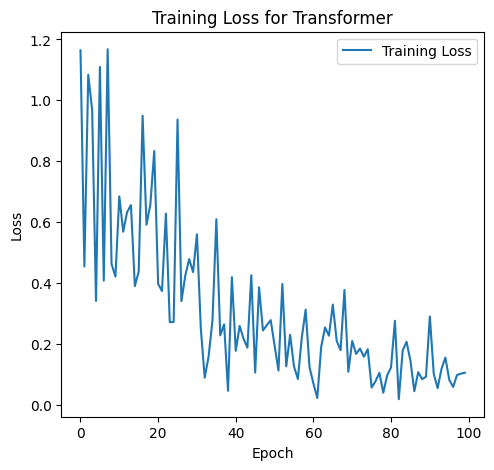

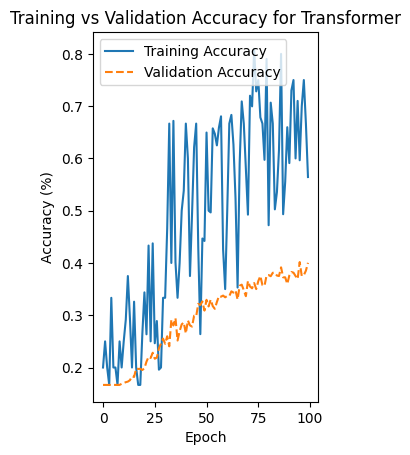

In [248]:
# Train and validate models 

# Parameters
vocab_size = len(word_to_ix) # vocab size from word_to_ix
embedding_dim = len(max(sentences, key=len)) # largest dimension of word embeddings
output_dim = len(tag_to_ix)  # number of unique tags

# Hyperparam for LSTM
hidden_dim = 128  # hidden dimension of LSTM

BiLSTM_NER = BiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss(ignore_index = -100)  
optimizer = optim.Adam(BiLSTM_NER.parameters(), lr=0.001)

LSTM_acc = train_plots(BiLSTM_NER, 'BiLSTM', criterion, optimizer)

# Hyper params for Transformer
d_model = 128                         # smaller embedding size (128 is common)
num_heads = 4                         # fewer heads since model is smaller
num_layers = 2                        # 2 encoder layers is sufficient
d_ff = 256                            # feedforward layer size
dropout = 0.1                         # regularization to prevent overfitting


transformer = TransformerNER(vocab_size, output_dim, d_model, num_heads, num_layers, d_ff, embedding_dim, dropout)

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Transformer_acc = train_plots(transformer, 'Transformer', criterion, optimizer)

---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best ones you obtained in the above stage).


In [249]:
# Function to evaluate the model and generate reports
def evaluate_model_with_metrics(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for sentences, labels in test_loader:
            output = model(sentences)
            all_preds.append(output.argmax(dim=-1).cpu().numpy())
            all_labels.append(labels.view(-1).cpu().numpy())

        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(all_labels)
    print(all_preds)

    print(np.shape(all_labels))
    print(np.shape(all_preds))
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    overall_accuracy = report['accuracy']
    print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')
    
    # Convert classification report to DataFrame
    df_report = pd.DataFrame(report).transpose()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    return df_report

# Find the best model and call the function
if LSTM_acc > Transformer_acc:
    best_model = BiLSTM_NER
else:
    best_model = transformer

print(tag_to_ix.keys())
df_results = evaluate_model_with_metrics(best_model, test_dataloader, tag_to_ix.keys())

# Display results table
print(df_results)


dict_keys(['O', 'I-LOC', 'I-PER', 'I-ORG', 'I-MISC'])
[   0    0    0 ... -100 -100 -100]
[0 0 0 ... 0 0 0]
(16811,)
(16811,)


ValueError: Number of classes, 6, does not match size of target_names, 5. Try specifying the labels parameter